This example takes you through the use of the BINARIESmodel to detect the circumbinary planet TIC172900988 b. This paper publishing the detection can be found here: [Lalitha et al. (2024)](https://academic.oup.com/mnras/article/527/2/2261/7420283?login=false).

The data was obtained using the SOPHIE spectrograph on the T193 at the Observatoire de Haute Provence.

First lets import **kima** and the TIC172900988 example (and numpy because why not)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kima
from kima.examples.TIC172900988 import TIC172900988

Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp310-macosx_10_16_x86_64
Running cmake --build & --install in /Users/thomasbaycroft/Documents/Python_packages/kima/build/cp310-cp

Next let us load the model and plot the raw data. Notice that this is a double-lined binary, there is a radial velocity time-series for each of the two stars. Notice also the huge spread of the data as close binaries have radial velocity amplitudes in the many tens of km/s.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='BJD - 2400000 [days]', ylabel='RV [m/s]'>)

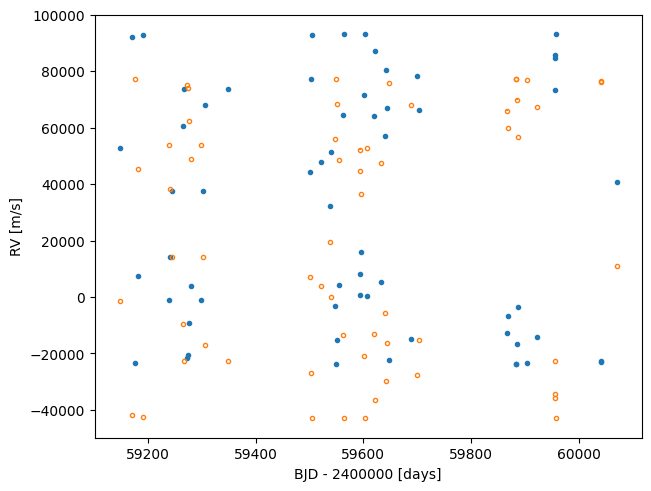

In [2]:
model = TIC172900988()
data=model.data
data.plot()

Below we show the setup of the model for TIC172900988, we first need to import a few more modules from **kima**

The data class is still the same RVData as in the other models, but we will give it a flag to indicate that it is adata from a double-lined binary.

In [3]:
from kima import RVData, BINARIESmodel
from kima.distributions import Uniform, Gaussian, ModifiedLogUniform, LogUniform, Kumaraswamy

Below is the setup as defined in the example, not that priors on the binary parameters appear tight, they are still adequate as the posterior constraints obtained cover a range multiple orders of magnitude smaller than the priors (see [Lalitha et al. 2024](https://academic.oup.com/mnras/article/527/2/2261/7420283?login=false).) They can still be relaxed a bit more but the sampling becomes slightly harder.

If running yourself try changing priors and parameters to see what happens.

In [4]:
def run_kima_TIC172900988(run=False, load=False, **kwargs):
    #Load in the data, in this case you can load in the data stored in the example model with:
    #   model = TIC172900988()
    #   data=model.data
    #if using the RVData function to load the data, you would need to specify double_lined=True
    data = RVData('SOPHIE.rv', units='kms', skip=2, double_lined=True)
    #Set the required model
    model = BINARIESmodel(fix=False, npmax=3, data=data)

    #Set the priors on the model
    model.Cprior = Uniform(25000,27000) #Systemic velocity (m/s)
    model.Jprior = ModifiedLogUniform(0.1,100) #Jitter (m/s) (added in quadrature to the RV uncertainties)

    model.conditional.Pprior = LogUniform(80, 1000) #Period prior (days), inner limit set by binary instability limit)
    model.conditional.Kprior = ModifiedLogUniform(1,200) #RV Semi-amplitude (m/s)
    model.conditional.eprior = Kumaraswamy(0.867,3.03) #Eccentricity (Kumaraswamy prior acts as beta distribution see Standing et al. (2022))
    model.conditional.wprior = Uniform(0,2*np.pi) #Argument of periastron
    model.conditional.phiprior = Uniform(0,2*np.pi) #Starting phase of orbit

    #Known object priors (used to set tight priors on the binary) Note: the known object can also be used for any previously detected planet (i.e. transiting)
    model.KO_Pprior = [Gaussian(19.658,0.01)] #Binary period (days)
    model.KO_Kprior = [Gaussian(58549,100)] #Binary semi-amplitude (m/s)
    model.KO_eprior = [Gaussian(0.448,0.01)] #Binary eccentricity
    model.KO_wprior = [Gaussian(1.23,0.01)] #Binary argument of periastron
    model.KO_wdotprior = [Gaussian(0,1000)] #Binary orbital precession (arcsec/yr)
    model.KO_phiprior = [Uniform(0,2*np.pi)] #Binary starting phase of orbit
    model.KO_qprior = [Gaussian(0.972,0.01)] #Binary mass ratio
    # model.KO_cosiprior = [] prior on cosin of inclination not necessary as the eclipsing flag is on (see below) so this is by default fixed to 0

    #Set the sampler parameters (change steps to set length of the run, change threads depending on machine, others are reasonable to leave)
    kwargs.setdefault('steps', 10000) #Number of steps to run
    kwargs.setdefault('num_threads', 4) #Number of threads (depends on number of cores available)
    kwargs.setdefault('num_particles', 2) #Number of MCMC particles to explore parameter space
    kwargs.setdefault('new_level_interval', 2000) #Number of sample steps taken before a new level is created
    kwargs.setdefault('save_interval', 500) #Number of steps taken before a sample is saved to the output (thinning param)    
    kwargs.setdefault('thread_steps', 50) #Number of steps each thread takes before communicating level info to other threads

    #Model settings only required for binary stars:
    model.star_mass = 1.2368 #Mass of the primary star (used for calculating the GR and Tidal corrections, not necessary for double-lined binaries
    model.tidal_correction = False #Set the model to calculate Post-Newtonian effects due to Tides (only important for very tight binaries)
    model.relativistic_correction = True #Set the model to calculate Post-Newtonian effects due to GR
    model.double_lined=True #True if double lined (SB2) binary
    model.eclipsing=True #Set this to True if you are fitting for an eclipsing binary (inc is then fixed to 90 deg)

    if run:
        kima.run(model, **kwargs)
    if load:
        res = kima.load_results(model)
        return model, res
    return model

While we could run this directly and you are encouraged to do so, we can also simply load in the results that have been pre-computed.

In [5]:
model, res = TIC172900988(run=False, load=True)

log(Z) = -671.05
Information = 59.99 nats
Effective sample size = 48420.8


Having loaded in the results, we can then plot various posterior distributions, starting with the posterior on the number of planets.

Np probability ratios:  [3.5754659  1.49367089]


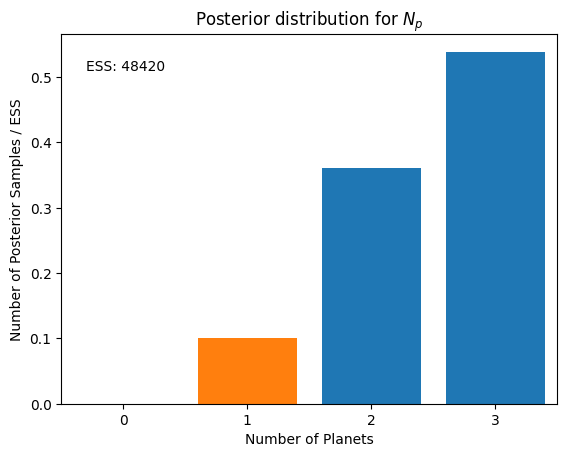

In [6]:
res.plot_posterior_np();

So the preferred number of planets is 1, with slight evidence for an additional Keplerian.

We then obtain the maximum likelihood sample (with Np restricted to 1) this will print the parameters of this posterior sample

In [7]:
p = res.maximum_likelihood_sample(Np=1)

Sample with the highest likelihood value  (logL = -607.97)
from samples with Np=1 only
-> might not be representative of the full posterior distribution

jitter:
  [32.50196312 40.47509655]
number of planets:  1
orbital parameters:           P           K          M0           e           w 
                      152.00311    41.60636     0.70362     0.23312     5.86918
number of known objects:  1
orbital parameters:           P           K           q          M0           e           w        wdot        cosi 
                       19.65789 58554.22389     0.97208     1.17988     0.44821     1.23136
   230.55318     0.00000
vsys_sec:  26034.64331772
vsys:  25987.57168015


Plot period histogram with the free planet search and the binary. First need to calculate lower and upper bounds for period histogram, since we want to include the peak from the binary (this should be fixed to be done automatically in a later release).

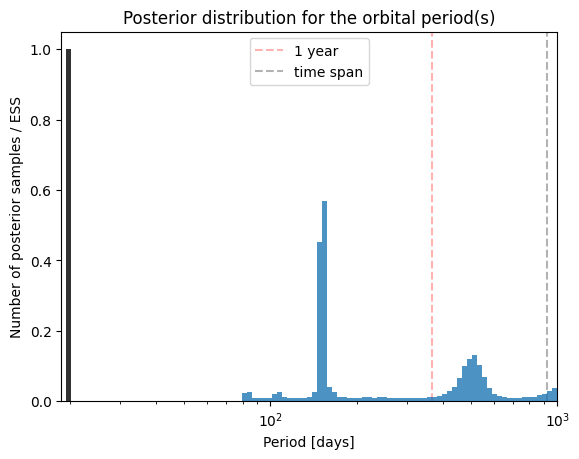

In [8]:
#Set the edges of the plot so that the period of the binary is seen (this will eventually get updated so that it is done automatically) 
P_bin = p[2]
P_upp = res.priors['Pprior'].upper

res.plot_posterior_periods(include_known_object=True,plims=(P_bin-1,P_upp));

We can now investigate some of the other parameters, here we see that there are two systemic velocities, one for each star of the double-lined binary. There is also a seperate RV jitter term for each star.

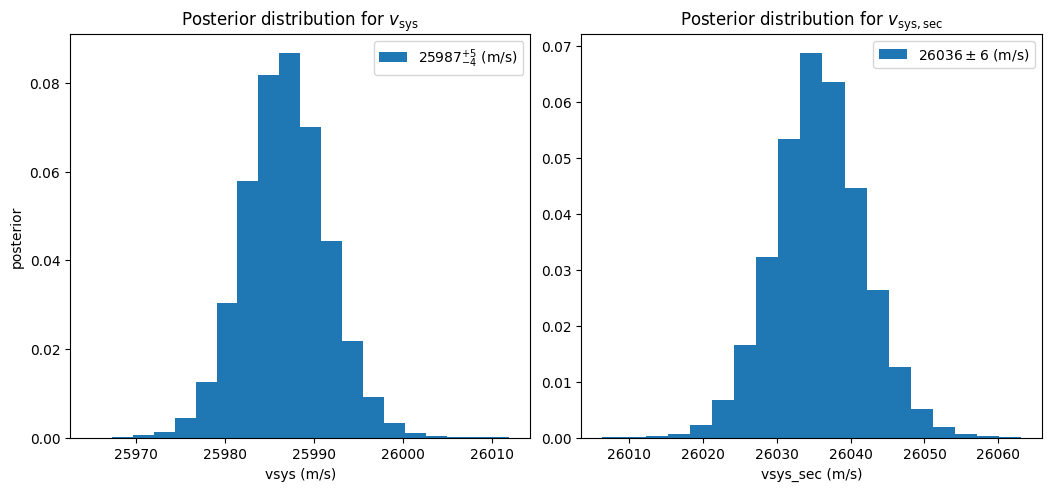

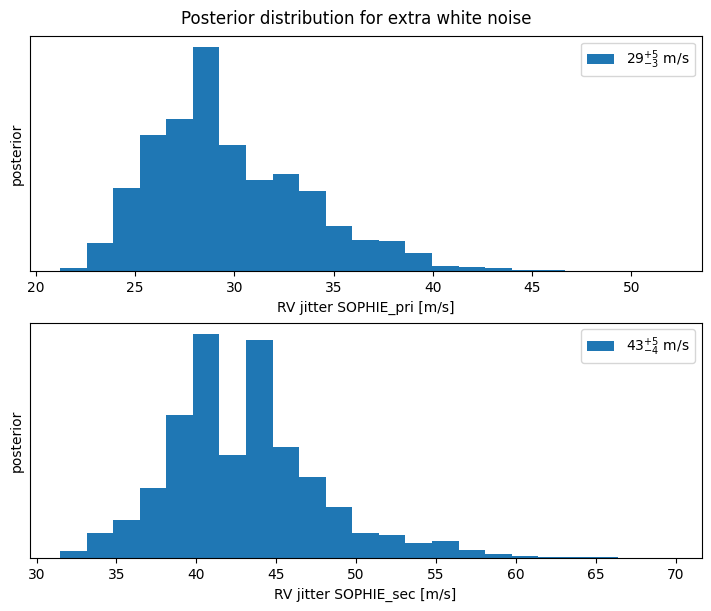

In [9]:
res.hist_vsys(show_prior=False);
res.hist_jitter();

We can plot the phase plot for the best-fitting solution, we can see the two sets of RVs for the double lined binary, with the secondary RVs being unfilled points.

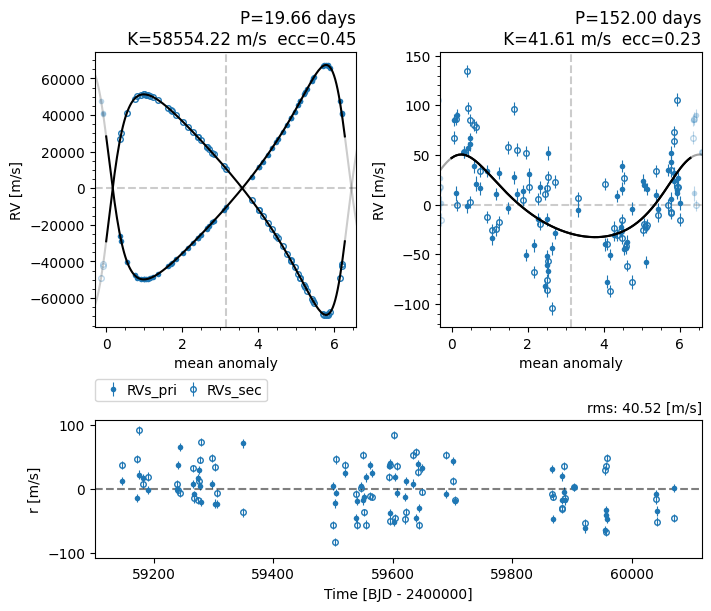

In [10]:
res.phase_plot(p);

We can also access the posterior samples directly and investigate those parameters. Since the BINARIESmodel fits for the apsidal precession of the binary, we now show the constraint this gives.

We see that there is a significant detection of apsidal precession, this is consistent with the apsidal precession rate that would be induced by the planet that has been detected above (see [Lalitha et al. 2024](https://academic.oup.com/mnras/article/527/2/2261/7420283?login=false))

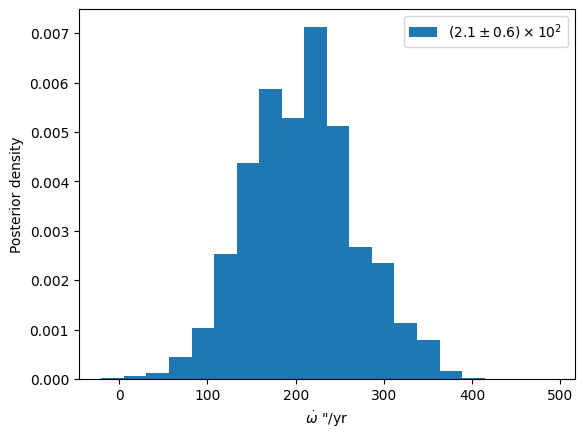

In [11]:
wdots = res.posteriors.KO.wdot
label = kima.pykima.utils.percentile68_ranges_latex(wdots)

fig, ax = plt.subplots()
ax.hist(wdots,bins=20,density=True,label=label)
ax.set(xlabel='$\dot{\omega}$ "/yr',ylabel='Posterior density')
ax.legend()

Notice that the value of the planet's eccentricity in the maximum likelihood sample plotted above is non-zero, but when the posterior distribution is plotted (as below) we see that the results are consistent with a circular orbit.

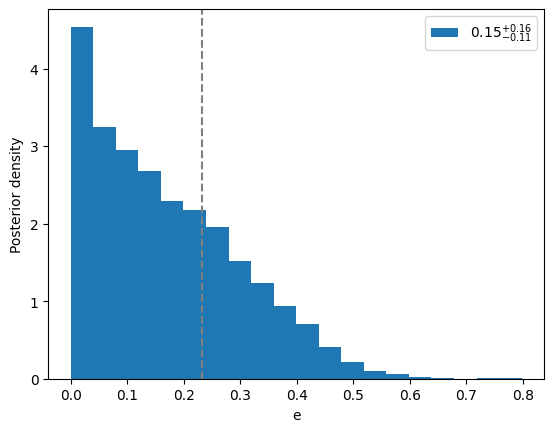

In [12]:
eccs = res.posteriors.e.T[0]
label = kima.pykima.utils.percentile68_ranges_latex(eccs)

fig, ax = plt.subplots()
ax.hist(eccs,bins=20,density=True,label=label)
ax.set(xlabel='e',ylabel='Posterior density')
ax.axvline(p[22],c='grey',ls='--')
ax.legend()